# Potential outcome model

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.float_format = "{:,.2f}".format

The [National Health Interview Survey (NHIS)](https://www.cdc.gov/nchs/nhis/index.htm) collects data on U.S. households since 1957. It covers a broad range of health-related topics, from medical conditions, health insurance, and the number of doctor visits to measures of physical activity. Here we focus on indicators relevant to the Potential outcome model (POM) framework. In particular, we will compare the health status of hospitalized and non-hospitalized individuals in 2018. For this purpose, we use answers to the survey question **During the past 12 months, has the respondent been hospitalized overnight?** with potential answers **Yes** and **No**, which we code as one and zero. Further, we consider answers to the questions **Would you say your health, in general, is excellent, very good, good, fair, poor?** where responses are coded as one for poor health up to five for excellent health. The survey also collects data on relevant characteristics as sex, age, level of education, hours worked last week, and total earnings.

Import the data set **nhis-initial.xslx** (raw file available in our [course repository](https://github.com/OpenSourceEconomics/ose-course-data-science/blob/master/problem-sets/potential-outcome-model/data/nhis-initial.xls)). Try to think of ways to answer the following questions: Are there more females or males? Are there more individuals who hold a degree or not?. Now try to relate individual characteristics to the hospitalization status. Are high or low earners/old or young people more often hospitalized?

In [4]:
df = pd.read_excel("data/nhis-initial.xls", index_col=0)
df.index.set_names("Individual", inplace=True)
df.head()

,sex,age,education,hours,earnings,hospitalized,health
Individual,,,,,,,
0,male,49,bachelor,32,low,0,3
1,male,37,PhD,40,high,0,3
2,female,36,bachelor,40,high,0,4
3,male,29,bachelor,25,middle,0,4
4,female,34,bachelor,40,middle,0,5


We will have to do so repeatedly, so let's streamline this process and set up a proper function.

In [7]:
def get_dataset(fname="initial"):
    df = pd.read_excel(f"data/nhis-{fname}.xls", index_col=0)
    df.index.set_names("Individual", inplace=True)
    return df

Let us get a basic feel for the data in front of us.

In [12]:
for column in df.columns:
    print("\n", column.capitalize())
    print(df.groupby("hospitalized")[column].describe())


 Sex
              count unique     top   freq
hospitalized                             
0             25320      2    male  13450
1              1496      2  female    938

 Age
                 count  mean   std   min   25%   50%   75%   max
hospitalized                                                    
0            25,320.00 43.45 13.87 13.00 32.00 43.00 54.00 85.00
1             1,496.00 45.95 15.17 18.00 33.00 45.00 58.25 85.00

 Education
              count unique       top   freq
hospitalized                               
0             25320      5  bachelor  14006
1              1496      5  bachelor    845

 Hours
                 count  mean   std  min   25%   50%   75%   max
hospitalized                                                   
0            25,320.00 40.60 13.49 1.00 38.00 40.00 45.00 99.00
1             1,496.00 38.78 14.00 1.00 33.75 40.00 43.00 99.00

 Earnings
              count unique  top   freq
hospitalized                          
0             25320

We want to study average age and working hours in more detail. What are their averages in our data?

In [35]:
stat = df["age"].mean()
print(f"Average age in the sample is {stat:.2f}")

Average age in the sample is 43.59


In [36]:
stat = df["hours"].mean()
print(f"Average of working hours per week in the sample is {stat:.0f}")

Average of working hours per week in the sample is 40


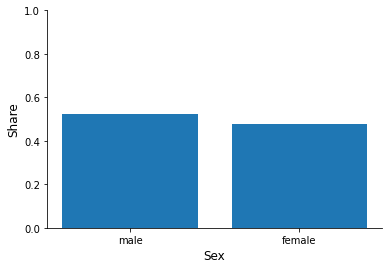

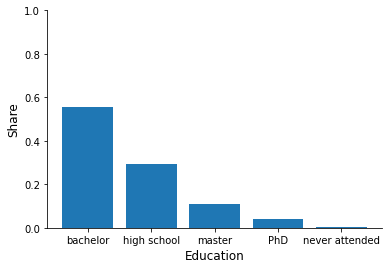

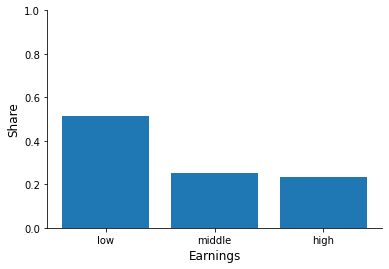

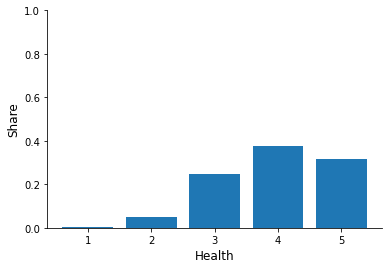

In [37]:
for column in ["sex", "education", "earnings", "health"]:

    fig, ax = plt.subplots()

    info = df[column].value_counts(normalize=True)
    x, y = info.index, info.to_numpy()

    ax.bar(x, y)

    ax.set_xlabel(column.capitalize())

    ax.set_ylim(None, 1)
    ax.set_ylabel("Share")

Now try to relate individual characteristics to the hospitalization status. 

In [47]:
df.groupby("hospitalized")[["age", "hours"]].mean()

,age,hours
hospitalized,,
0,43.45,40.60
1,45.95,38.78


Let's practice some plotting and set up a grouped bar chart to explore differences in the observables by hospitalization status. Some additional explanations are available as part of the `matplotlib` gallery [here](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html).

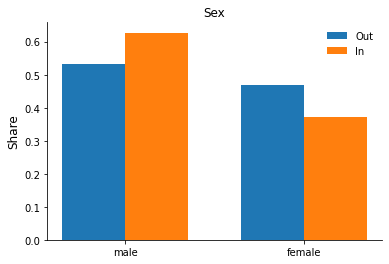

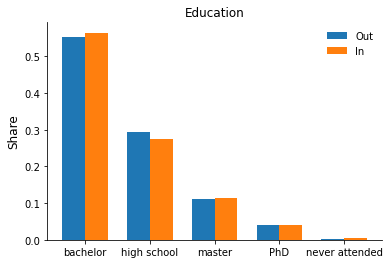

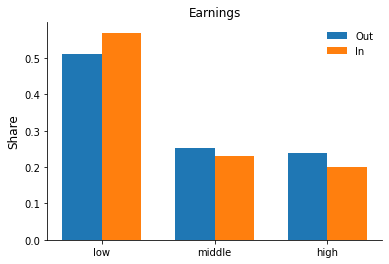

In [98]:
width = 0.35
for column in ["sex", "education", "earnings"]:

    fig, ax = plt.subplots()

    rslt = df.groupby("hospitalized")[column].value_counts(normalize=True)
    y_out, y_in = rslt[0].to_numpy(), rslt[1].to_numpy()
    labels = rslt.index.get_level_values(1).unique()

    x = np.array(range(len(y_out)))

    ax.bar(x - width / 2, y_out, width, label="Out")
    ax.bar(x + width / 2, y_in, width, label="In")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.legend()
    ax.set_title(column.capitalize())
    ax.set_ylabel("Share")

## Task A.2

Compute the average health status of hospitalized and non-hospitalized individuals. Who is healthier on average? What could be a reason for this difference?

In [99]:
df.groupby("hospitalized")["health"].mean().to_frame()

,health
hospitalized,
0,3.97
1,3.59


## Task A.3

Adjust the data set for the POM framework, with health status as the outcome and hospitalization as the treatment status.

In [100]:
df = get_dataset()

df.rename(columns={"health": "Y", "hospitalized": "D"}, inplace=True)

df["Y_1"] = np.where(df["D"] == 1, df["Y"], np.nan)
df["Y_0"] = np.where(df["D"] == 0, df["Y"], np.nan)

df.head()

,sex,age,education,hours,earnings,D,Y,Y_1,Y_0
Individual,,,,,,,,,
0,male,49,bachelor,32,low,0,3,NaN,3.00
1,male,37,PhD,40,high,0,3,NaN,3.00
2,female,36,bachelor,40,high,0,4,NaN,4.00
3,male,29,bachelor,25,middle,0,4,NaN,4.00
4,female,34,bachelor,40,middle,0,5,NaN,5.00


## Task A.4

Compute the naive estimate for the average treatment effect (ATE)

In [101]:
stat = df["Y_1"].mean() - df["Y_0"].mean()
print(f"Our naive estimate is {stat:.1f}")

Our naive estimate is -0.4


## Task B.1

As we’ve seen in the lecture, in reality, we can only ever observe one counterfactual; however, when simulating data, we can bypass this problem. The (simulated) data set nhis-simulated.xslx (raw file available in our [course repository](https://github.com/OpenSourceEconomics/ose-course-data-science/blob/master/problem-sets/potential-outcome-model/data/nhis-simulated.xls)) contains counterfactual outcomes, i.e., outcomes under control for individuals assigned to the treatment group and vice versa. Derive and compute the average outcomes in the two observable and two unobservables states. Design them similar
to Table 2.3 in Morgan & Winship (2014).

In [102]:
df = get_dataset("simulated")

In [103]:
rslt = df.groupby("D")[["Y_1", "Y_0"]].mean()

rslt.columns = ["E[Y_1|D]", "E[Y_0|D]"]
rslt.index = ["Untreated", "Treated"]

rslt

,E[Y_1|D],E[Y_0|D]
Untreated,4.87,3.97
Treated,3.59,3.90


## Task B.2 

From here on we assume that 5% of the population take the treatment. Derive and explain Equation (2.10) from Morgan & Winship (2014) for the naive estimator as a decomposition of true ATE, baseline bias, and differential treatment effect bias.

This derivation is straightforward.



## Task B.3

Compute the naive estimate and true value of the ATE for the simulated data. Is the naive estimator upwardly or downwardly biased? Calculate the baseline bias and differential treatment effect bias. How could we interpret these biases in our framework of health status of hospitalized and non-hospitalized respondents?

In [104]:
pi = 0.05

# naive estimate
naive = rslt.loc["Treated", "E[Y_1|D]"] - rslt.loc["Untreated", "E[Y_0|D]"]

# baseline bias
base = rslt.loc["Treated", "E[Y_0|D]"] - rslt.loc["Untreated", "E[Y_0|D]"]

# differential effect
diff = 0
diff += rslt.loc["Treated", "E[Y_1|D]"] - rslt.loc["Treated", "E[Y_0|D]"]
diff -= rslt.loc["Untreated", "E[Y_1|D]"] - rslt.loc["Untreated", "E[Y_0|D]"]
diff *= 1 - pi

# true average treatment effect
true = 0
true += pi * (rslt.loc["Treated", "E[Y_1|D]"] - rslt.loc["Treated", "E[Y_0|D]"])
true += (1 - pi) * (
    rslt.loc["Untreated", "E[Y_1|D]"] - rslt.loc["Untreated", "E[Y_0|D]"]
)
print(f"naive: {naive:.2f}, base: {base:.2f}, diff: {diff:.2f}, true: {true:.2f}")

# We can also test the relationships just to be sure.
np.testing.assert_almost_equal(true, naive - (base + diff), decimal=10)

naive: -0.38, base: -0.07, diff: -1.14, true: 0.84


## Task B.4 

Under which assumptions does the naive estimator provide the ATE?

We need the *stable unit treatment value assumption* and independence between potential outcomes and the treatment.

## References

* Winship, C., and Morgan, S. L. (2014). [*Counterfactuals and causal inference: Methods and principles for social research*](https://www.cambridge.org/de/academic/subjects/sociology/sociology-general-interest/counterfactuals-and-causal-inference-methods-and-principles-social-research-2nd-edition?format=PB). Cambridge, England: Cambridge University Press.

* Angrist, J. D., and Pischke, J. (2009). [*Mostly harmless econometrics: An empiricists companion*](https://press.princeton.edu/titles/8769.html). Princeton, NJ: Princeton University Press.

* [National Health Interview Survey.](https://www.cdc.gov/nchs/nhis/index.htm) (2018). National Center for Health Statistics.